In [1]:
import math
import numpy as np
import torch
from scipy.stats import wasserstein_distance

# -------------------------
# utils
# -------------------------

def set_seed(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)

def to_f32_cpu(x):
    # safest form across torch versions
    return x.detach().cpu().float()

def center_inplace(x):
    x -= x.mean(dim=0, keepdim=True)
    return x

def l2_normalize_inplace(x, eps=1e-12):
    x /= (x.norm(dim=1, keepdim=True) + eps)
    return x

def random_unit_vectors(n, d, seed=0):
    rng = np.random.default_rng(seed)
    x = rng.standard_normal((n, d), dtype=np.float32)
    x /= np.linalg.norm(x, axis=1, keepdims=True) + 1e-12
    return x

# -------------------------
# 1) Isotropy without covariance matrix
# -------------------------

def isotropy_metrics_lowmem(x, iters=20):
    n, d = x.shape

    trace = (x.pow(2).sum() / n).item()

    # power iteration for lambda_max
    v = torch.randn(d)
    v /= v.norm()
    for _ in range(iters):
        v = (x.T @ (x @ v)) / n
        v /= v.norm()
    lambda_max = (v @ (x.T @ (x @ v)) / n).item()

    # Hutchinson entropy estimate
    H = 0.0
    for _ in range(8):
        z = torch.randn(d)
        Cz = (x.T @ (x @ z)) / n
        p = (z * Cz).abs() / trace
        H -= float((p * torch.log(p + 1e-12)).sum())
    erank = math.exp(H / 8)

    return {
        "trace": trace,
        "lambda_max_over_mean": lambda_max / (trace / d),
        "erank_over_d": erank / d,
    }

# -------------------------
# 2) Pairwise cosine distribution
# -------------------------

def cosine_distribution(x, pairs=50_000, seed=0, batch=4096):
    n, d = x.shape
    g = torch.Generator().manual_seed(seed)

    out = np.empty(pairs, dtype=np.float32)
    done = 0
    while done < pairs:
        b = min(batch, pairs - done)
        i = torch.randint(0, n, (b,), generator=g)
        j = torch.randint(0, n, (b,), generator=g)
        j[i == j] = (j[i == j] + 1) % n
        out[done:done+b] = (x[i] * x[j]).sum(dim=1).numpy()
        done += b

    base = random_unit_vectors(4096, d, seed+1)
    rng = np.random.default_rng(seed+2)
    ii = rng.integers(0, base.shape[0], size=pairs)
    jj = (ii + rng.integers(1, base.shape[0], size=pairs)) % base.shape[0]
    cos0 = (base[ii] * base[jj]).sum(1)

    return {
        "mean": float(out.mean()),
        "std": float(out.std()),
        "wasserstein_to_random": float(wasserstein_distance(out, cos0)),
    }

# -------------------------
# 3) kNN concentration (blockwise, no FAISS)
# -------------------------

def knn_concentration_blockwise(x, k=50, queries=1000, refs=5000, seed=0, block=1024):
    rng = np.random.default_rng(seed)
    n, d = x.shape

    Q = x[rng.choice(n, size=min(queries, n), replace=False)]
    R = x[rng.choice(n, size=min(refs, n), replace=False)]

    knn_means = []

    for q in Q:
        best = torch.full((k,), -1.0)
        for i in range(0, R.shape[0], block):
            sims = (R[i:i+block] @ q)
            best = torch.topk(torch.cat([best, sims]), k).values
        knn_means.append(best.mean().item())

    Q0 = torch.from_numpy(random_unit_vectors(len(Q), d, seed+1))
    R0 = torch.from_numpy(random_unit_vectors(len(R), d, seed+2))

    knn0 = []
    for q in Q0:
        best = torch.full((k,), -1.0)
        for i in range(0, R0.shape[0], block):
            sims = (R0[i:i+block] @ q)
            best = torch.topk(torch.cat([best, sims]), k).values
        knn0.append(best.mean().item())

    return {
        "knn_mean": float(np.mean(knn_means)),
        "baseline_knn_mean": float(np.mean(knn0)),
        "delta": float(np.mean(knn_means) - np.mean(knn0)),
    }

# -------------------------
# 4) Hopkins via random projection (no PCA)
# -------------------------

def hopkins_random_projection(x, out_dim=64, m=1000, seed=0):
    rng = np.random.default_rng(seed)
    n, d = x.shape

    P = torch.from_numpy(
        rng.standard_normal((d, out_dim), dtype=np.float32) / math.sqrt(out_dim)
    )
    z = (x @ P).numpy()

    idx = rng.choice(n, size=min(m, n), replace=False)
    Xm = z[idx]

    mins, maxs = z.min(0), z.max(0)
    Um = rng.uniform(mins, maxs, size=Xm.shape)

    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=2).fit(z)
    w = nn.kneighbors(Xm, return_distance=True)[0][:,1]
    u = nn.kneighbors(Um, return_distance=True)[0][:,0]

    return float(u.sum() / (u.sum() + w.sum()))

# -------------------------
# Master
# -------------------------

def evaluate_embedding_lowmem(E, seed=0):
    set_seed(seed)

    X = to_f32_cpu(E)
    center_inplace(X)

    Xu = l2_normalize_inplace(X.clone())

    return {
        "shape": tuple(E.shape),
        "isotropy": isotropy_metrics_lowmem(X),
        "cosine": cosine_distribution(Xu),
        "knn": knn_concentration_blockwise(Xu),
        "hopkins": hopkins_random_projection(X),
    }


In [2]:
from pprint import pprint
import torch
from huggingface_hub import hf_hub_download


def get_E(repo_id="littlePanic99/nanochat", filename="base/d20/model_021400.pt"):
    ckpt = hf_hub_download(repo_id=repo_id, filename=filename, local_files_only=True)
    emb = torch.load(ckpt, map_location="cpu")["transformer.wte.weight"]
    return emb.detach()

E = get_E()


/Users/rjbiggs/rjbiggs99/projects/nanochat/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
E

tensor([[ 0.1943,  2.1562, -0.1719,  ...,  0.9688,  1.1016,  0.4277],
        [-1.0938,  0.5820, -0.2734,  ...,  0.4004,  0.2402,  1.1328],
        [ 0.4902,  0.5078,  0.6445,  ...,  1.3047, -1.5547,  0.5508],
        ...,
        [-0.1289, -0.7031,  0.0728,  ..., -0.7383,  0.7812, -0.0806],
        [ 0.7812, -0.6992,  0.4043,  ...,  0.1426, -0.7656, -0.2656],
        [-0.7812,  0.9258,  0.9727,  ..., -0.4609, -0.3008, -1.3125]],
       dtype=torch.bfloat16)

In [4]:
results = evaluate_embedding_lowmem(E, seed=0)
pprint(results)

{'cosine': {'mean': 8.815635374048725e-05,
            'std': 0.04580644890666008,
            'wasserstein_to_random': 0.013528860568283129},
 'hopkins': 0.7214668071140832,
 'isotropy': {'erank_over_d': 1.4586791513179338,
              'lambda_max_over_mean': 16.044053989369377,
              'trace': 307625.375},
 'knn': {'baseline_knn_mean': 0.07423919096589088,
         'delta': 0.07381624417006971,
         'knn_mean': 0.1480554351359606},
 'shape': (65536, 1280)}


## Embedding Diagnostics Summary

**Isotropy**
- `lambda_max_over_mean ≈ 16`  
  Strong anisotropy; a small number of directions dominate variance.
- `erank_over_d ≈ 1.46`  
  Entropy-based effective rank; combined with λmax indicates very uneven variance distribution.
- **Takeaway:** Embeddings are far from isotropic.

**Cosine Similarity Distribution**
- `mean ≈ 0`  
  Proper centering and normalization.
- `std ≈ 0.046` vs random baseline `≈ 1/√d ≈ 0.028`  
  Angular distribution is wider than random.
- `wasserstein_to_random ≈ 0.0135`  
  Measurable deviation from random-unit vectors.
- **Takeaway:** Pairwise angles show structured, non-random geometry.

**kNN Concentration**
- `knn_mean ≈ 0.148`  
- Random baseline `≈ 0.074`
- `delta ≈ +0.074`
- **Takeaway:** Strong neighborhood concentration; points are much closer to nearest neighbors than random vectors.

**Hopkins Statistic**
- `≈ 0.72`  
  (0.5 = uniform random, →1 = highly clustered)
- **Takeaway:** Clear clustering and non-uniform spatial structure.

**Overall Conclusion**
The embedding space is **highly structured and anisotropic**, with dominant directions, non-random angular structure, and strong clustering. This is typical of trained language-model embeddings, especially after instruction or fine-tuning.


In [5]:
import numpy as np
import torch
from sklearn.cluster import MiniBatchKMeans

def to_f32_cpu(x):
    return x.detach().cpu().float()

def center_inplace(x):
    x -= x.mean(dim=0, keepdim=True)
    return x

def l2_normalize_inplace(x, eps=1e-12):
    x /= (x.norm(dim=1, keepdim=True) + eps)
    return x

def fast_cluster_embedding_ids(X, k=256, batch_size=2048, seed=0):
    """
    X: (n, d) L2-normalized torch tensor on CPU
    returns: dict {cluster_id: [indices]}
    """
    if torch.is_tensor(X):
        X = X.numpy()

    km = MiniBatchKMeans(
        n_clusters=k,
        batch_size=batch_size,
        n_init="auto",
        random_state=seed,
    )

    labels = km.fit_predict(X)

    clusters = {}
    for i, c in enumerate(labels):
        clusters.setdefault(c, []).append(i)

    return clusters

Xu = l2_normalize_inplace(center_inplace(to_f32_cpu(E)))
clusters = fast_cluster_embedding_ids(Xu, k=256)


In [6]:
repo_id = "littlePanic99/nanochat"

base_filename = "base/d20/model_021400.pt"
mid_filename = "mid/d20/model_000809.pt"
sft_filename = "sft/d20/model_000700.pt"
tokenizer_filename = "tokenizer/latest/tokenizer.pkl"


In [7]:
import pickle
from huggingface_hub import hf_hub_download

with open(hf_hub_download(repo_id=repo_id, filename=tokenizer_filename, local_files_only=True), "rb") as f:
    tokenizer = pickle.load(f)

def token_str(enc, tid: int):
    return enc.decode_bytes([tid]).decode("utf-8", errors="replace")
    

In [8]:
for k, cluster in clusters.items():
    sample = [token_str(tokenizer, tid).strip() for tid in cluster[0:20]]
    print(f"{k:<5} {len(cluster):<5} {cluster[0:20]}")
    print(", ".join(sample))
    print()


219   70    [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
 , , , , , , , ,, , , , , , , , , , , 

76    156   [9, 221, 222, 223, 1713, 2769, 3505, 3895, 4557, 4952, 5591, 5692, 5821, 6388, 6531, 6746, 7143, 7744, 8490, 8739]
, �, �, �, researc, htt, citiz, destro, porary, conclud, proport, weap, algorith, holid, clust, cryst, compris, interpre, htt, reprene

127   328   [10, 41, 46, 307, 791, 807, 810, 830, 970, 1022, 1139, 1165, 1182, 1254, 1385, 1405, 1551, 1600, 1854, 2101]
, ), ., ., ?, )., ),, :, .”, ), .., ,”, ||, )., .", .”, |, ,", !, ."

58    385   [32, 33, 34, 39, 40, 42, 43, 44, 45, 47, 58, 59, 61, 62, 63, 65, 73, 93, 95, 124]
, !, ", ', (, *, +, ,, -, /, :, ;, =, >, ?, A, I, ], _, |

203   416   [35, 36, 38, 60, 64, 91, 92, 94, 125, 126, 1626, 2379, 3000, 5601, 5913, 5927, 6234, 6247, 6345, 8037]
#, $, &, <, @, [, \, ^, }, ~, __, //, ____, *, >, https, ________, <, www, (s

235   293   [37, 915, 1457, 1754, 2387, 2436, 3066, 3421, 35

## Observations from Embedding Clusters

- **Strong semantic coherence**  
  Most clusters align cleanly with semantic fields such as punctuation, numbers, units, morphology (`-tion`, `-ing`), parts of speech, and topical domains (health, geography, religion, technology).

- **Tokenizer structure is clearly exposed**  
  Very tight clusters appear for:
  - punctuation and symbols  
  - casing variants (`Word`, `word`, `WORD`)  
  - affixes and suffixes (`-tion`, `-ity`, `-ing`, `-based`)  
  These reflect tokenizer and subword effects rather than pure semantics.

- **Lexical → conceptual gradient**  
  - Small, extremely tight clusters correspond to form-based or lexical tokens.  
  - Larger, looser clusters correspond to higher-level semantic concepts.

- **Part-of-speech separation**  
  Clear grouping of:
  - function words (`of`, `and`, `to`, `with`)  
  - verbs (actions, processes)  
  - adjectives (qualitative scales: big/small, good/bad)  
  - nouns grouped by domain.

- **Domain knowledge emergence**  
  Clusters reflect real-world ontologies:
  - medicine (diseases, anatomy, treatment)  
  - geography (countries, regions)  
  - science vs humanities  
  - religion, mythology, and history.

- **Long-tail and rare tokens isolate naturally**  
  Singleton or very small clusters correspond to:
  - rare proper nouns  
  - non-Latin scripts  
  - corrupted or partial subwords.  
  This behavior is expected and healthy.

- **Consistency with global metrics**  
  Earlier diagnostics (high anisotropy, Hopkins statistic, kNN concentration) are consistent with:
  - dense semantic cores  
  - sparse tails  
  - strong overall clustering tendency.

**Overall conclusion**  
The embedding space is well-structured: linguistic form, syntax, and world knowledge are all clearly represented. Tokenizer artifacts are visible but separable from higher-level semantic organization.


In [9]:
import math
import numpy as np
import torch
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score

def cluster_labels_kmeans(X, k=256, seed=0, batch_size=2048):
    if torch.is_tensor(X):
        X = X.numpy()
    km = MiniBatchKMeans(
        n_clusters=k,
        batch_size=batch_size,
        n_init="auto",
        random_state=seed,
    )
    return km.fit_predict(X)

def l2_normalize_np(X, eps=1e-12):
    nrm = np.linalg.norm(X, axis=1, keepdims=True) + eps
    return X / nrm

def stability_test_projection(Xu, k=256, proj_dim=128, seed=0):
    """
    Xu: (n,d) L2-normalized torch tensor (CPU) or numpy array
    Returns: ARI between full-D and projected clustering, and small-cluster counts.
    """
    # full-D clustering
    lab_full = cluster_labels_kmeans(Xu, k=k, seed=seed)

    # random projection
    if torch.is_tensor(Xu):
        X = Xu
        d = X.shape[1]
        torch.manual_seed(seed + 1)
        P = torch.randn(d, proj_dim) / math.sqrt(proj_dim)
        Xp = (X @ P).numpy()
    else:
        X = torch.from_numpy(Xu)
        d = X.shape[1]
        torch.manual_seed(seed + 1)
        P = torch.randn(d, proj_dim) / math.sqrt(proj_dim)
        Xp = (X @ P).numpy()

    Xp = l2_normalize_np(Xp)

    # projected clustering
    lab_proj = cluster_labels_kmeans(Xp, k=k, seed=seed)

    # agreement
    ari = adjusted_rand_score(lab_full, lab_proj)

    # small cluster counts
    def small_counts(lab, thr=10):
        counts = np.bincount(lab, minlength=k)
        return int((counts <= thr).sum()), counts

    small_full, cnt_full = small_counts(lab_full)
    small_proj, cnt_proj = small_counts(lab_proj)

    return {
        "ARI_full_vs_proj": float(ari),
        "small_clusters_full_(<=10)": small_full,
        "small_clusters_proj_(<=10)": small_proj,
    }

def to_f32_cpu(x):
    return x.detach().cpu().float()

def center_inplace(x):
    x -= x.mean(dim=0, keepdim=True)
    return x

def l2_normalize_inplace(x, eps=1e-12):
    x /= (x.norm(dim=1, keepdim=True) + eps)
    return x

In [10]:
Xu = l2_normalize_inplace(center_inplace(to_f32_cpu(E)))
res = stability_test_projection(Xu, k=256, proj_dim=128, seed=0)
print(res)


{'ARI_full_vs_proj': 0.04228651281936646, 'small_clusters_full_(<=10)': 70, 'small_clusters_proj_(<=10)': 10}


## Cluster Stability Test Summary

### What the numbers mean

- **ARI ≈ 0.04**  
  Almost no agreement between the full-dimensional (1280-D) clustering and the 128-D projected clustering.

- **Small clusters: 70 → 10**  
  The majority of low-member clusters disappear after random projection.

### Interpretation

- Most small clusters are **not stable semantic structure**.
- They arise from a combination of:
  - **Strong anisotropy** in the original embedding space  
  - **High ambient dimensionality (1280)** relative to the intrinsic semantic structure  
  - **k-means over-partitioning** along thin or low-variance directions

### In short

The embedding space is **functionally wider than necessary for this clustering objective**.  
For semantic clustering, many dimensions encode fragile distinctions that do not survive mild dimensionality reduction.


In [11]:
import math
import numpy as np
import torch

def _rand_proj(X, m, seed=0):
    torch.manual_seed(seed)
    d = X.shape[1]
    P = torch.randn(d, m) / math.sqrt(m)
    Xp = X @ P
    Xp /= (Xp.norm(dim=1, keepdim=True) + 1e-12)
    return Xp

def _knn_indices_blockwise(X, Q_idx, k=20, block=2048):
    # X: (n,d) torch CPU, L2-normalized
    n, d = X.shape
    Q = X[Q_idx]
    out = []
    for q in Q:
        best_vals = torch.full((k,), -1.0)
        best_idx  = torch.full((k,), -1, dtype=torch.long)
        for i in range(0, n, block):
            sims = X[i:i+block] @ q
            vals, idx = torch.topk(sims, k)
            idx = idx + i
            # merge
            all_vals = torch.cat([best_vals, vals])
            all_idx  = torch.cat([best_idx, idx])
            sel = torch.topk(all_vals, k).indices
            best_vals = all_vals[sel]
            best_idx  = all_idx[sel]
        out.append(best_idx.numpy())
    return np.stack(out, 0)

def pick_proj_dim_by_knn_overlap(Xu, dims=(32,64,96,128,192,256), k=20, q=500, seed=0, target=0.8):
    """
    Xu: (n,d) torch CPU, L2-normalized
    returns: list of results + recommended dim
    """
    rng = np.random.default_rng(seed)
    n = Xu.shape[0]
    Q_idx = torch.from_numpy(rng.choice(n, size=min(q,n), replace=False)).long()

    knn_full = _knn_indices_blockwise(Xu, Q_idx, k=k)

    results = []
    for m in dims:
        Xp = _rand_proj(Xu, m, seed=seed+1+m)
        knn_proj = _knn_indices_blockwise(Xp, Q_idx, k=k)
        # overlap per query
        overlap = np.mean([len(set(a).intersection(b))/k for a,b in zip(knn_full, knn_proj)])
        results.append({"proj_dim": m, "knn_overlap": float(overlap)})

    rec = next((r["proj_dim"] for r in results if r["knn_overlap"] >= target), results[-1]["proj_dim"])
    return results, rec

In [12]:
Xu = l2_normalize_inplace(center_inplace(to_f32_cpu(E)))
results, rec = pick_proj_dim_by_knn_overlap(Xu, target=0.8)
print(results)
print("recommended:", rec)


[{'proj_dim': 32, 'knn_overlap': 0.101}, {'proj_dim': 64, 'knn_overlap': 0.1718}, {'proj_dim': 96, 'knn_overlap': 0.23240000000000002}, {'proj_dim': 128, 'knn_overlap': 0.28959999999999997}, {'proj_dim': 192, 'knn_overlap': 0.3635}, {'proj_dim': 256, 'knn_overlap': 0.4268}]
recommended: 256


# Numbers

In [24]:
numbers_cluster = 131

cluster_items = [token_str(tokenizer, tid).strip() for tid in clusters[numbers_cluster]]
print(len(cluster_items))
print(sorted(cluster_items))


306
['-II', '-III', '-IV', '-eight', '-fifth', '-fifths', '-five', '-four', '-fourth', '-fourths', '-hundred', '-nine', '-nineteenth', '-seven', '-six', '-sixth', '-ten', '-tenth', '-third', '-thirds', '-three', '-twentieth', '-two', '0', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1½', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'Dozens', 'Eight', 'Eight', 'Eighteenth', 'Eighth', 'Eighty', 'Eleven', 'Fifteen', 'Fifth', 'Fifth', 'Fifty', 

In [37]:
member_sizes = []

for k, cluster in clusters.items():
    for idx in cluster:
        member_sizes.append((idx, len(cluster)))
    
    if len(cluster) < 4:
        sample = [token_str(tokenizer, tid).strip() for tid in cluster[0:20]]
        print(f"{k:<5} {len(cluster):<5} {cluster[0:20]}", ", ".join(sample))

94    3     [1390, 4827, 5779] ify, ifying, ifies
188   2     [1396, 15783] keep, keep
2     2     [1907, 7404] protect, protecting
158   3     [2077, 32572, 34470] skin, Skin, skin
124   2     [2656, 57562] believe, believe
222   3     [3854, 19717, 41884] milk, Milk, Milk
192   3     [4173, 5107, 23986] Internet, internet, Internet
233   1     [5353] igation
167   3     [6365, 11586, 13719] protocol, protocols, Protocol
161   1     [7013] pharm
217   2     [7318, 46680] dates, Dates
42    3     [8082, 31579, 45346] availability, availability, Availability
171   3     [9218, 38340, 54917] blank, Blank, blank
111   2     [9245, 51612] wooden, Wooden
104   2     [10345, 17884] action, actions
109   2     [10490, 39021] persistent, Persistent
1     2     [11534, 30195] tunnel, Tunnel
91    2     [11594, 40716] beef, Beef
239   3     [11657, 40375, 41933] telephone, telephones, Telephone
3     2     [12665, 23332] impairment, impairments
71    2     [14842, 51246] Hart, Hart
72    1     [

[(0, 4.248495242049359), (100, 3.6888794541139363), (200, 6.963189985870238), (300, 6.144185634125646), (400, 5.860786223465865), (500, 5.953243334287785), (600, 6.144185634125646), (700, 6.380122536899765), (800, 5.860786223465865), (900, 5.924255797414532)]
[(55600, 6.298949246855942), (55700, 7.441906728051625), (55800, 6.1675164908883415), (55900, 6.490723534502507), (56000, 5.811140992976701), (56100, 6.659293919683638), (56200, 6.490723534502507), (56300, 5.869296913133774), (56400, 5.0106352940962555), (56500, 5.700443573390687), (56600, 5.8664680569332965), (56700, 6.803505257608338), (56800, 3.713572066704308), (56900, 6.432940092739179), (57000, 6.2766434893416445), (57100, 5.62040086571715), (57200, 6.715383386334681), (57300, 6.694562058521095), (57400, 6.45833828334479), (57500, 6.169610732491456), (57600, 5.4116460518550396), (57700, 6.45833828334479), (57800, 7.149131598557407), (57900, 5.726847747587197), (58000, 5.680172609017068), (58100, 6.447305862541213), (58200, 7

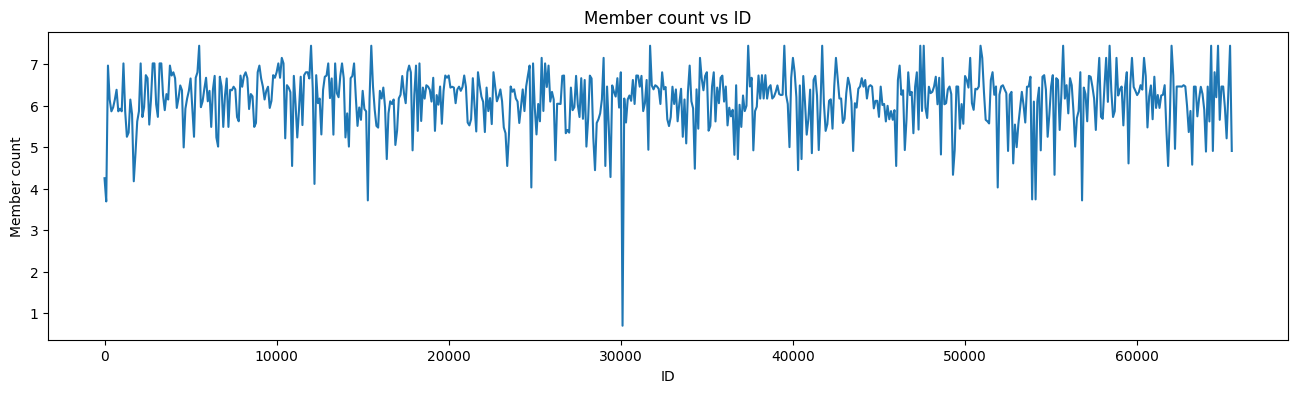

In [34]:
import matplotlib.pyplot as plt
import math


def plot_counts(data):
    data_sorted = sorted(data, key=lambda x: x[0])
    data_sorted = [(v, math.log(c)) for v, c in data_sorted if v % 100 == 0]
    print(data_sorted[0:10])
    print(data_sorted[-100:])

    ids = [x[0] for x in data_sorted]
    counts = [x[1] for x in data_sorted]

    plt.figure(figsize=(16, 4))
    plt.plot(ids, counts)
    plt.xlabel("ID")
    plt.ylabel("Member count")
    plt.title("Member count vs ID")
    plt.show()


plot_counts(member_sizes)
